In [8]:
from py2neo import Graph, NodeSelector
from pandas import DataFrame
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker, style
from textwrap import wrap

style.use('ggplot')

%matplotlib inline
plt.rcParams["figure.figsize"] = [12,6]

graph = Graph("http://localhost:7474", password = "admin")

In [2]:
data1 = DataFrame(graph.data("MATCH (z:Zakazka) WITH z.druh as d, count(distinct(z)) as a RETURN d, a"))

In [3]:
data2 = data1.copy(deep=True)
data2['d'] = data1['d']\
    .replace('', 'ostatní')\
    .replace('koncesní řízení', 'ostatní')\
    .replace('zakázka dělená na části (zmr, zpr)', 'ostatní')\
    .replace('zakázka malého rozsahu na rámcovou smlouvu', 'ostatní')\
    .replace('zakázka malého rozsahu s aukcí', 'ostatní')\
    .replace('soutěžní dialog', 'ostatní')\
    .replace('jednací řízení bez uveřejnění s použitím elektronické aukce', 'ostatní')\
    .replace('soutěž o návrh', 'ostatní')\
    .replace('přímé zadání', 'ostatní')
data2 = data2.groupby(['d']).sum()
data2['d'] = data2.index
data2['d2'] = data2['d'].apply({'jednací řízení bez uveřejnění':3, 'jednací řízení s uveřejněním':4, 'zakázka malého rozsahu':5, 'zjednodušené podlimitní řízení':2, 'otevřené řízení':0, 'užší řízení':1, 'ostatní':6}.get)
data2 = data2.sort_values(['d2'])
data2

a                               d  d2
d                                                                        
otevřené řízení                  6643                 otevřené řízení   0
užší řízení                       630                     užší řízení   1
zjednodušené podlimitní řízení   7108  zjednodušené podlimitní řízení   2
jednací řízení bez uveřejnění    2495   jednací řízení bez uveřejnění   3
jednací řízení s uveřejněním      221    jednací řízení s uveřejněním   4
zakázka malého rozsahu          24446          zakázka malého rozsahu   5
ostatní                            58                         ostatní   6

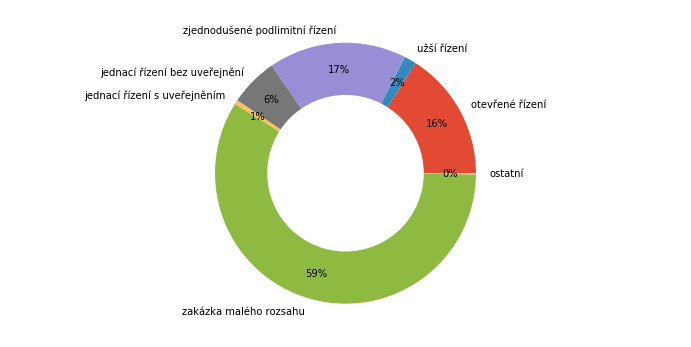

In [9]:
fig, axes = plt.subplots()
axes.axis('equal')
axes.pie(data2['a'], labels=data2['d'], autopct='%.0f%%', startangle=0, pctdistance=0.8)

centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

fig.savefig("vystup/zakazky-podil.pdf", bbox_inches='tight')

In [5]:
data3 = DataFrame(graph.data("MATCH (z:Zakazka)-[:UCHAZEC_ZAKAZKA]-(s:Subjekt) WITH z, count(distinct(s)) as c WITH z.druh as d, avg(c) as a RETURN d, a"))

In [6]:
data4 = data3.copy(deep=True)
data4.index = data4['d']
data4['d2'] = data4['d'].apply({'jednací řízení bez uveřejnění':4, 'jednací řízení s uveřejněním':5, 'zakázka malého rozsahu':6, 'zjednodušené podlimitní řízení':3, 'otevřené řízení':1, 'užší řízení':2}.get)
data4 = data4.sort_values(['d2'])
data4 = data4.drop('')
data4

a                               d   d2
d                                                                            
otevřené řízení                 3.608589                 otevřené řízení  1.0
užší řízení                     3.733333                     užší řízení  2.0
zjednodušené podlimitní řízení  3.518609  zjednodušené podlimitní řízení  3.0
jednací řízení bez uveřejnění   1.143333   jednací řízení bez uveřejnění  4.0
jednací řízení s uveřejněním    1.864865    jednací řízení s uveřejněním  5.0
zakázka malého rozsahu          2.344991          zakázka malého rozsahu  6.0

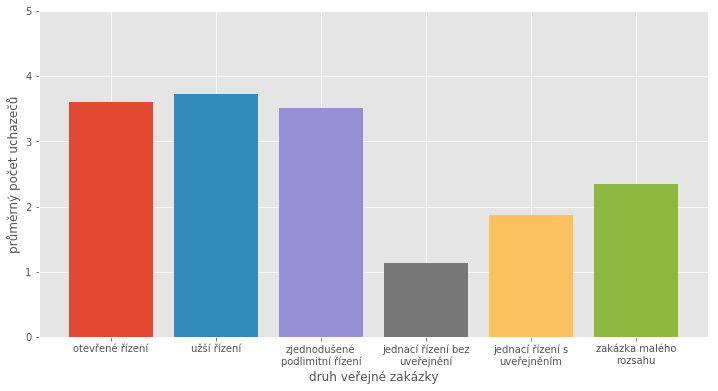

In [10]:
colors = ['#E14933', '#338ABD', '#988ED4', '#777777', '#FBC15E', '#8EB941']
fig, axes = plt.subplots()
axes.set_xlabel("druh veřejné zakázky")
axes.set_ylabel("průměrný počet uchazečů")
axes.set_ylim([0,5])
labels = ['\n'.join(wrap(l, 20)) for l in data4["d"]]
labels = [''] + labels
axes.set_xticklabels(labels)
axes.bar(data4["d2"], data4["a"],color=colors)
fig.savefig("vystup/zakazky-uchazeci.pdf", bbox_inches='tight')